# Algoritmo Genético Aplicado à Logística da Rede BuonoPreço
Este notebook demonstra como aplicar **Algoritmos Genéticos (AGs)** para otimizar rotas de entrega em um contexto logístico realista, utilizando a biblioteca **DEAP**.

O problema simula a rede BuonoPreço, que possui filiais em diferentes cidades, e a cada dia apenas um subconjunto dessas filiais necessita de reabastecimento.

A documentação do Projeto DEAD está disponível em:

https://deap.readthedocs.io/en/master/index.html

In [398]:
# !pip install deap

In [399]:
# Importação das bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools
import math

## 1. Definição do Problema
Aqui definimos as cidades (filiais) da rede BuonoPreço e suas coordenadas simuladas em um plano 2D.

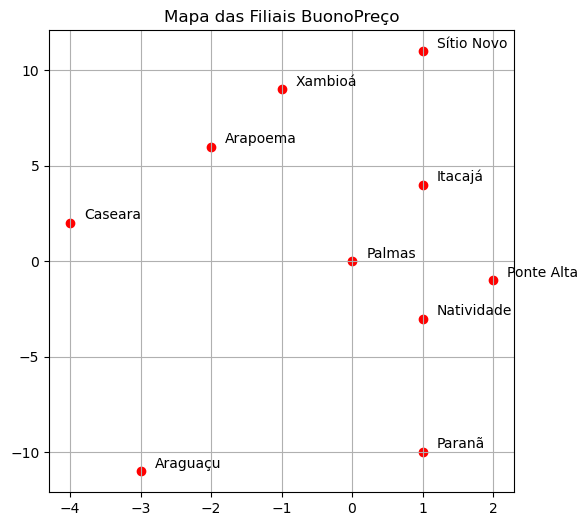

In [400]:
# Lista de cidades e suas coordenadas (x, y)
cidades = {
    "Palmas": (0, 0),
    "Araguaçu": (-3, -11),
    "Arapoema": (-2, 6),
    "Caseara": (-4, 2),
    "Itacajá": (1, 4),
    "Natividade": (1, -3),
    "Paranã": (1, -10),
    "Ponte Alta": (2, -1),
    "Sítio Novo": (1, 11),
    "Xambioá": (-1, 9)
}

nomes_cidades = list(cidades.keys())
coords = np.array(list(cidades.values()))

# Visualização das cidades
plt.figure(figsize=(6,6))
plt.scatter(coords[:,0], coords[:,1], c='red')
for i, nome in enumerate(nomes_cidades):
    plt.text(coords[i,0]+0.2, coords[i,1]+0.2, nome)
plt.title('Mapa das Filiais BuonoPreço')
plt.grid()
plt.show()

## 2. Variabilidade de Demanda
Nem todas as filiais precisam de entrega todos os dias. Simulamos essa variabilidade selecionando aleatoriamente 70% das cidades a cada execução. Para fins didáticos, o abastecimento parte de um Centro de Distribuição em Palmas, sendo um ponto diferente do Supemercado BuonoPreço na própria cidade, ou seja, a matriz em Palmas também necessita de abastecimento.

In [401]:
def selecionar_cidades_ativas(porcentagem=0.6):
    num_ativas = max(2, int(len(nomes_cidades) * porcentagem))
    return random.sample(nomes_cidades, num_ativas)

cidades_ativas = selecionar_cidades_ativas()
print('Cidades que necessitam de entrega hoje:', cidades_ativas)

Cidades que necessitam de entrega hoje: ['Sítio Novo', 'Itacajá', 'Natividade', 'Xambioá', 'Paranã', 'Caseara']


## 3. Funções Auxiliares

Definição das funções para calcular distâncias entre cidades e avaliar a distância total de uma rota.

In [402]:
def distancia(cidade1, cidade2):
    x1, y1 = cidades[cidade1]
    x2, y2 = cidades[cidade2]
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def distancia_rota(individuo):
    dist_total = 0
    for i in range(len(individuo)):
        cidade_atual = cidades_ativas[individuo[i]]
        prox_cidade = cidades_ativas[individuo[(i + 1) % len(individuo)]]
        dist_total += distancia(cidade_atual, prox_cidade)
    return dist_total

## 4. Configuração do Algoritmo Genético (DEAP)

Utilizamos a biblioteca **DEAP** para definir o AG, usando representação **permutacional**, crossover PMX e mutação por troca.


In [403]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
indices_cidades = list(range(len(cidades_ativas)))
toolbox.register('indices', random.sample, indices_cidades, len(indices_cidades))
# toolbox.register('indices', random.sample, cidades_ativas, len(cidades_ativas))
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

def avaliar(individuo):
    return (distancia_rota(individuo),)

toolbox.register('evaluate', avaliar)
toolbox.register('mate', tools.cxPartialyMatched)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.2)
toolbox.register('select', tools.selTournament, tournsize=3)


## 5. Execução do Algoritmo Genético

Aqui executamos o AG por 100 gerações, monitorando a convergência e o melhor indivíduo encontrado. Nesse ponto é possível reconhecer o laço principal do AG:

![Loop](https://sousamaf.github.io/AI-Lab/img/ai-ga-loop.png)


In [404]:
random.seed(42)

pop = toolbox.population(n=50)
NGEN = 80 # Número de gerações
CXPB, MUTPB = 0.8, 0.2 # Porcentagem de cruzamento e mutação

melhores_dist = []

for gen in range(NGEN):
    offspring = toolbox.select(pop, len(pop)) # Seleciona os indivíduos para reprodução
    offspring = list(map(toolbox.clone, offspring)) # Clona os indivíduos selecionados

    for child1, child2 in zip(offspring[::2], offspring[1::2]): # Bloco do Cruzamento
        # print(f'Geração {gen+1}, cruzando {child1} e {child2}')
        if random.random() < CXPB:
            toolbox.mate(child1, child2) 
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring: # Bloco de Mutação
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop[:] = offspring
    fits = [ind.fitness.values[0] for ind in pop]
    melhores_dist.append(min(fits))

melhor_ind = tools.selBest(pop, 1)[0]  # Ensure this is a single individual (list of city names)
rota_final = [cidades_ativas[i] for i in melhor_ind]
print('\nMelhor rota encontrada:', rota_final)
print('Distância total:', distancia_rota(melhor_ind))

# Se quiser visualizar as coordenadas da melhor rota:
rota_coords = [cidades[nome] for nome in rota_final]
print('Coordenadas da melhor rota:', rota_coords)


Melhor rota encontrada: ['Sítio Novo', 'Itacajá', 'Natividade', 'Paranã', 'Caseara', 'Xambioá']
Distância total: 44.4442002306101
Coordenadas da melhor rota: [(1, 11), (1, 4), (1, -3), (1, -10), (-4, 2), (-1, 9)]


## 6. Visualização dos Resultados

Plotamos a curva de convergência e a rota final encontrada pelo algoritmo.


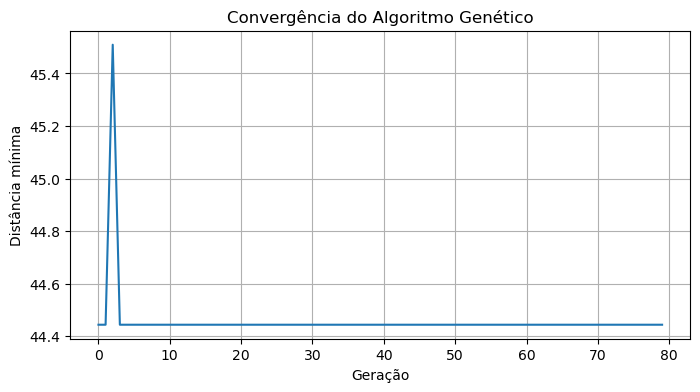

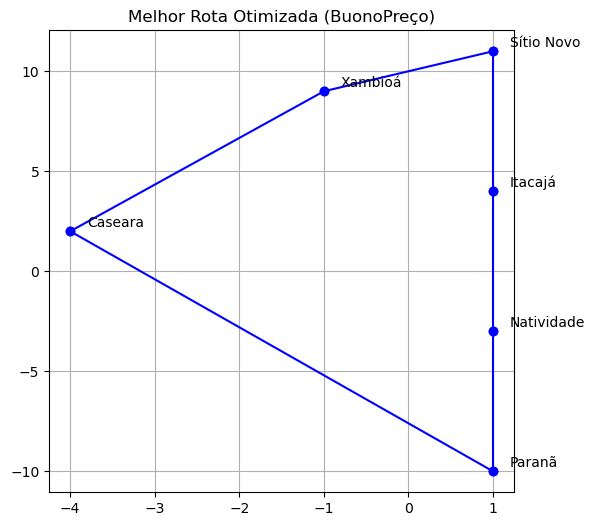

In [406]:
# Gráfico de convergência
plt.figure(figsize=(8,4))
plt.plot(melhores_dist)
plt.title('Convergência do Algoritmo Genético')
plt.xlabel('Geração')
plt.ylabel('Distância mínima')
plt.grid()
plt.show()

# Plot da melhor rota encontrada
plt.figure(figsize=(6,6))
for i in range(len(rota_final)):
    cidade_atual = rota_final[i]
    prox_cidade = rota_final[(i + 1) % len(rota_final)]
    x1, y1 = cidades[cidade_atual]
    x2, y2 = cidades[prox_cidade]
    plt.plot([x1, x2], [y1, y2], 'b-o')
    plt.text(x1+0.2, y1+0.2, cidade_atual)

plt.title('Melhor Rota Otimizada (BuonoPreço)')
plt.grid()
plt.show()